## unzip data files from Kaist here

In [3]:
!unzip -q set01.zip
# !unzip -q ./drive/MyDrive/acv_project/weights.zip

In [4]:
# from models import *
import numpy as np
from scipy.io import loadmat as import_mat
from matplotlib import pyplot as plt
from matplotlib.cm import viridis as cm_viridis
import torch
from glob import glob
from tqdm import tqdm_notebook as tqdm
from torchvision import transforms
from datetime import datetime
from PIL import Image
from collections import defaultdict
import torch
import argparse
from importlib import reload
from torch.nn.utils import clip_grad_norm_
import torchvision.transforms.functional as tvF

In [5]:
class RRC(transforms.RandomResizedCrop):
    def __call__(self, imgs):
        """
        Args:
            img (PIL Image): Image to be cropped and resized.

        Returns:
            PIL Image: Randomly cropped and resized image.
        """

        for im in range(1, len(imgs)):
            assert imgs[im].size == imgs[0].size

        i, j, h, w = self.get_params(imgs[0], self.scale, self.ratio)

        for imgCount in range(len(imgs)):
            imgs[imgCount] = tvF.resized_crop(imgs[imgCount], i, j, h, w, self.size, self.interpolation)

        return imgs

In [6]:
class BrainDataset(torch.utils.data.Dataset):
    
    def __init__(self, input_files):
        self.files = input_files
        


        self.crop = RRC(128)
        self.tensor = transforms.ToTensor()
        
        # self.inpt = transforms.Compose([transforms.Resize(128),
        #                         transforms.ToTensor()])
        
        # self.crop = transforms.RandomCrop(128)
        
        self.annotation = lambda x : x.replace("lwir", "visible")
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):

        inpt, target = self.crop([Image.open(self.files[index]),
                                  Image.open(self.annotation(self.files[index]))])
        
        inpt = self.tensor(inpt)
        target = self.tensor(target)
                  
        return {
            "input" : (inpt - 0.5)/0.5,
            "target" : (target - 0.5)/0.5,
        }

dataset = glob("./V00*/lwir/*.jpg")

train_dataset = BrainDataset(dataset[:int(0.7*len(dataset))])
val_dataset = BrainDataset(dataset[int(len(dataset)*0.7):])

train_sampler = torch.utils.data.DataLoader(train_dataset,num_workers=2, pin_memory=True, batch_size=32, shuffle=True)
val_sampler = torch.utils.data.DataLoader(val_dataset, num_workers=2, pin_memory=True, batch_size=32, shuffle=True)

In [7]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [8]:
batch_size = 32

image_size = 128

device = torch.device("cuda:0")

nc = 3

nz = 100

ngf = 64

ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5


In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.unconditional_noise = nn.Sequential(
            nn.ConvTranspose2d(128, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conditional_inp = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),)
        
        self.conditional_otpt = nn.Sequential(
            nn.ConvTranspose2d( 256, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, noise, ir):
        ir =  self.conditional_inp(ir)
        noise = self.unconditional_noise(noise)

        return self.conditional_otpt(torch.cat([ir, noise], axis=1))

In [10]:
generator = Generator(ngpu=1)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.unconditional_noise = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conditional_inp = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),)
        
        self.conditional_otpt = nn.Sequential(
            nn.Conv2d(ndf * 4, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, noise, ir):
        ir =  self.conditional_inp(ir)
        noise = self.unconditional_noise(noise)

        return self.conditional_otpt(torch.cat([ir, noise], axis=1))

In [12]:
netD = Discriminator(ngpu=1).to(device)
netG = Generator(ngpu=1).to(device)

In [13]:
noise = torch.randn(b_size, 128, 1, 1, device=device)
ir = torch.randn(b_size, 3, 128, 128, device=device)

NameError: ignored

In [14]:
criterion = nn.BCELoss()


fixed_noise = torch.randn(batch_size, 128, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
fixed_ir = next(iter(val_sampler))['input'].to(device)

In [16]:
fixed_ir.shape, fixed_noise.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32, 128, 1, 1]))

In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(209):
    # For each batch in the dataloader
    for i, data in enumerate(train_sampler, 0):
        
        netD.zero_grad()

        ir_inpt = data['input'].to(device)
        real_cpu = data['target'].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu, ir_inpt).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 128, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise, ir_inpt)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), ir_inpt).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, ir_inpt).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_sampler),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_sampler)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise, fixed_ir).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            torch.save(netG.state_dict(), f="./drive/MyDrive/acv_project/weights/google_generator_{}".format(iters))
            torch.save(netD.state_dict(), f="./drive/MyDrive/acv_project/weights/google_discriminator_{}".format(iters))

        iters += 1

Starting Training Loop...
[0/5][0/176]	Loss_D: 0.0080	Loss_G: 5.8102	D(x): 0.9999	D(G(z)): 0.0077 / 0.0060
[0/5][50/176]	Loss_D: 0.0025	Loss_G: 7.4070	D(x): 0.9984	D(G(z)): 0.0009 / 0.0010
[0/5][100/176]	Loss_D: 0.0066	Loss_G: 6.8458	D(x): 0.9949	D(G(z)): 0.0015 / 0.0015
[0/5][150/176]	Loss_D: 0.0232	Loss_G: 9.5316	D(x): 0.9773	D(G(z)): 0.0001 / 0.0001
[1/5][0/176]	Loss_D: 0.0152	Loss_G: 7.7279	D(x): 0.9855	D(G(z)): 0.0005 / 0.0006
[1/5][50/176]	Loss_D: 0.0005	Loss_G: 9.0344	D(x): 0.9997	D(G(z)): 0.0002 / 0.0002
[1/5][100/176]	Loss_D: 0.0006	Loss_G: 8.4191	D(x): 0.9998	D(G(z)): 0.0004 / 0.0004
[1/5][150/176]	Loss_D: 0.0027	Loss_G: 6.5973	D(x): 0.9993	D(G(z)): 0.0020 / 0.0018
[2/5][0/176]	Loss_D: 0.0010	Loss_G: 7.6249	D(x): 0.9997	D(G(z)): 0.0008 / 0.0007
[2/5][50/176]	Loss_D: 0.0012	Loss_G: 9.0399	D(x): 0.9990	D(G(z)): 0.0002 / 0.0002
[2/5][100/176]	Loss_D: 0.0092	Loss_G: 6.8256	D(x): 0.9919	D(G(z)): 0.0011 / 0.0016
[2/5][150/176]	Loss_D: 0.0005	Loss_G: 10.2880	D(x): 0.9996	D(G(z)): 0.

In [ ]:
ls ./drive/MyDrive

 acv_project/
 Assignment.gdoc
'Automatic Image Colorization.gslides'
'Bank account details.gdoc'
'Base Paper.gdoc'
 checkpoint
'Colab Notebooks'/
'Copy of Access YouTube Analytics API Example.gsheet'
'Copy of Pious.gslides'
 Courses.gsheet
 cv_material.gdoc
 Engagement.gsheet
'Epson iPrint'/
 Expense.gsheet
'Finger detection.gdoc'
 gan_weights/
 General.gdoc
"GSOC'18.pdf"
'Hackathon 1st Draft.gdoc'
 hindi_lm_large.model
 HuffmanCoding.m
 id_imgs_training_p_80.txt
 id_testing_p_80.txt
 id_training_p_80.txt
'IIIT SOP.gdoc'
'Industrial Mini Project PPT-1.gslides'
'Industrial Mini Project PPT-2.gslides'
'Internship Completion Certificate final.gdoc'
 INTERSPEECH.pdf
 KeyDynamics/
 KeyDynamics.ipynb
 leads.gsheet
'Letter Head TripShire.gdoc'
'LIGHT-REFLECTION AND REFRACTION.ppt.gslides'
 lstm1.ipynb
'microsoft sop.gdoc'
 middle.gdoc
 midsem_nlp/
 model.pth
'Money Details.gdoc'
 Money.gsheet
'Mutual_NDA Karan.gdoc'
 narendra_modi_results.gsheet
'NB2 - Fit a Short Sample.ipynb'
'Nips competi

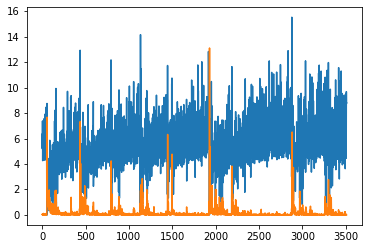

In [39]:
plt.plot(G_losses)
plt.plot(D_losses)

In [23]:
fake1 = netG(fixed_noise, fixed_ir).detach().cpu()

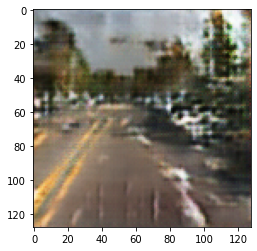

In [37]:
plt.imshow(fake[6].detach().cpu().numpy().transpose([1, 2, 0])*0.5 + 0.5)

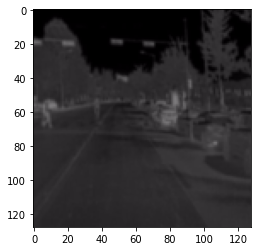

In [32]:
plt.imshow(ir_inpt[6].cpu().numpy().transpose([1, 2, 0])*0.5 + 0.5)

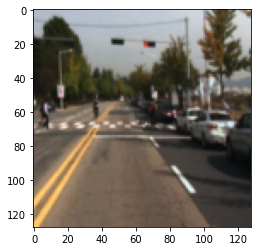

In [33]:
plt.imshow(real_cpu[6].cpu().numpy().transpose([1, 2, 0])*0.5 + 0.5)

In [ ]:
!nvidia-smi

Tue Dec 22 13:04:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    28W /  70W |   1703MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
nn.load_state_dict(torch.load("../drive/MyDrive/acv_project/weights/4_image_translation_19"))

<All keys matched successfully>

In [ ]:
def log_sum_exp(x):
    """ numerically stable log_sum_exp implementation that prevents overflow """
    # TF ordering
    axis  = len(x.size()) - 1
    m, _  = torch.max(x, dim=axis)
    m2, _ = torch.max(x, dim=axis, keepdim=True)
    return m + torch.log(torch.sum(torch.exp(x - m2), dim=axis))


def log_prob_from_logits(x):
    """ numerically stable log_softmax implementation that prevents overflow """
    # TF ordering
    axis = len(x.size()) - 1
    m, _ = torch.max(x, dim=axis, keepdim=True)
    return x - m - torch.log(torch.sum(torch.exp(x - m), dim=axis, keepdim=True))

def discretized_mix_logistic_loss(l, x):
    """ log-likelihood for mixture of discretized logistics, assumes the data has been rescaled to [-1,1] interval """
    # Pytorch ordering
    x = x.permute(0, 2, 3, 1)
    l = l.permute(0, 2, 3, 1)
    xs = [int(y) for y in x.size()]
    ls = [int(y) for y in l.size()]
   
    # here and below: unpacking the params of the mixture of logistics
    nr_mix = int(ls[-1] / 10) 
    # print(ls, nr_mix)
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3]) # 3 for mean, scale, coef
    means = l[:, :, :, :, :nr_mix]
    # log_scales = torch.max(l[:, :, :, :, nr_mix:2 * nr_mix], -7.)
    log_scales = torch.clamp(l[:, :, :, :, nr_mix:2 * nr_mix], min=-7.)
   
    coeffs = F.tanh(l[:, :, :, :, 2 * nr_mix:3 * nr_mix])
    # here and below: getting the means and adjusting them based on preceding
    # sub-pixels
    x = x.contiguous()
    x = x.unsqueeze(-1) + torch.autograd.Variable(torch.zeros(xs + [nr_mix]).cuda(), requires_grad=False)
    m2 = (means[:, :, :, 1, :] + coeffs[:, :, :, 0, :]
                * x[:, :, :, 0, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    m3 = (means[:, :, :, 2, :] + coeffs[:, :, :, 1, :] * x[:, :, :, 0, :] +
                coeffs[:, :, :, 2, :] * x[:, :, :, 1, :]).view(xs[0], xs[1], xs[2], 1, nr_mix)

    means = torch.cat((means[:, :, :, 0, :].unsqueeze(3), m2, m3), dim=3)
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = F.sigmoid(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = F.sigmoid(min_in)
    # log probability for edge case of 0 (before scaling)
    log_cdf_plus = plus_in - F.softplus(plus_in)
    # log probability for edge case of 255 (before scaling)
    log_one_minus_cdf_min = -F.softplus(min_in)
    cdf_delta = cdf_plus - cdf_min  # probability for all other cases
    mid_in = inv_stdv * centered_x
    # log probability in the center of the bin, to be used in extreme cases
    # (not actually used in our code)
    log_pdf_mid = mid_in - log_scales - 2. * F.softplus(mid_in)

    # now select the right output: left edge case, right edge case, normal
    # case, extremely low prob case (doesn't actually happen for us)

    # this is what we are really doing, but using the robust version below for extreme cases in other applications and to avoid NaN issue with tf.select()
    # log_probs = tf.select(x < -0.999, log_cdf_plus, tf.select(x > 0.999, log_one_minus_cdf_min, tf.log(cdf_delta)))

    # robust version, that still works if probabilities are below 1e-5 (which never happens in our code)
    # tensorflow backpropagates through tf.select() by multiplying with zero instead of selecting: this requires use to use some ugly tricks to avoid potential NaNs
    # the 1e-12 in tf.maximum(cdf_delta, 1e-12) is never actually used as output, it's purely there to get around the tf.select() gradient issue
    # if the probability on a sub-pixel is below 1e-5, we use an approximation
    # based on the assumption that the log-density is constant in the bin of
    # the observed sub-pixel value
    
    inner_inner_cond = (cdf_delta > 1e-5).float()
    inner_inner_out  = inner_inner_cond * torch.log(torch.clamp(cdf_delta, min=1e-12)) + (1. - inner_inner_cond) * (log_pdf_mid - np.log(127.5))
    inner_cond       = (x > 0.999).float()
    inner_out        = inner_cond * log_one_minus_cdf_min + (1. - inner_cond) * inner_inner_out
    cond             = (x < -0.999).float()
    log_probs        = cond * log_cdf_plus + (1. - cond) * inner_out
    log_probs        = torch.sum(log_probs, dim=3) + log_prob_from_logits(logit_probs)
    
    return -torch.sum(log_sum_exp(log_probs))

In [ ]:
import torch.optim as optim

# criterion = torch.nn.MSELoss()
criterion = discretized_mix_logistic_loss
optimizer = optim.Adam(nn.parameters(), lr=1e-4)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

task_type = "image_translation_logistic"
time_date = "{}".format(datetime.now())
tensorboard_writer = SummaryWriter("../drive/MyDrive/acv_project/log/{}/{}".format(task_type, time_date))

In [ ]:
plots = []
running_loss = 0.
controller = tqdm(total=int(len(train_dataset) * 10/32))

best_val_loss = 0
epoch = 0
while epoch < 20:
    train_loss = []
    train_acc = []
    for each_batch_sample in train_sampler:
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = nn(each_batch_sample['input'].to(nn.device))
        CbCr_target = each_batch_sample['target'].to(nn.device, non_blocking=True)
        loss = criterion(outputs, CbCr_target)

        loss.backward()
        
        # clip_grad_norm_(nn.parameters(), 2)
        optimizer.step()
        
        
        running_loss += loss.item()
        controller.update(1)
        controller.set_postfix({"loss":running_loss/controller.n})
        train_loss.append(loss.item())
        
        # acc = np.count_nonzero(outputs.argmax(1).detach().cpu().numpy() == CbCr_target.cpu().numpy())/np.prod(CbCr_target.shape)
        # train_acc.append(acc)
        
        
        tensorboard_writer.add_scalar("loss/batch/train", loss.item(), controller.n)
        # tensorboard_writer.add_scalar("acc/batch/train", acc, controller.n)
        
    
        
    tensorboard_writer.add_scalar("loss/epoch/train", np.mean(train_loss), epoch)
    # tensorboard_writer.add_scalar("acc/epoch/train", np.mean(train_acc), epoch)

    with torch.no_grad():
        val_loss = []
        val_acc = []
        for each_batch_sample in val_sampler:
            outputs = nn(each_batch_sample['input'].to(nn.device))
            CbCr_target = each_batch_sample['target'].to(nn.device, non_blocking=True)
            loss = criterion(outputs, CbCr_target)
            # acc = np.count_nonzero(outputs.argmax(1).detach().cpu().numpy() == CbCr_target.cpu().numpy())
            # val_acc.append(acc/np.prod(CbCr_target.shape))
            val_loss.append(loss.item())
            
    tensorboard_writer.add_scalar("loss/epoch/val", np.mean(val_loss), epoch)
    # tensorboard_writer.add_scalar("acc/epoch/val", np.mean(val_acc), epoch)
    
    torch.save(nn.state_dict(), "../drive/MyDrive/acv_project/weights/logistic_{}_{}".format(task_type, epoch))
    
    epoch += 1
    print("Epoch {}, Train Loss {}, Val Loss {}".format(epoch, np.mean(train_loss), np.mean(val_loss)))
print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1, Train Loss 11147160.0, Val Loss 11166434.127272727
Epoch 2, Train Loss 11058743.23828125, Val Loss 11142407.818181818
Epoch 3, Train Loss 11015653.296875, Val Loss 11138370.090909092
Epoch 4, Train Loss 11021059.125, Val Loss 11142487.218181819
Epoch 5, Train Loss 10985169.42578125, Val Loss 11117280.236363636
Epoch 6, Train Loss 10989163.7421875, Val Loss 11106569.563636364
Epoch 7, Train Loss 10972721.828125, Val Loss 11067649.10909091


In [ ]:
!nvidia-smi

Mon Dec 21 16:18:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    29W /  70W |  14387MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
inp = np.array(each_batch_sample['input']).transpose([0, 2, 3, 1])
target = np.array(each_batch_sample['target']).transpose([0, 2, 3, 1])
output = np.array(sample_from_discretized_mix_logistic(outputs, 10).detach().cpu()).transpose([0, 2, 3, 1])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
random = np.random.randint(len(inp))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


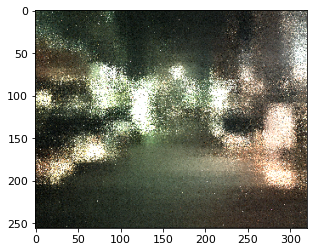

In [ ]:
plt.imshow(output[random]+1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


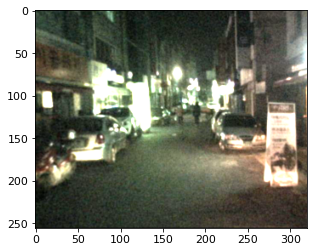

In [ ]:
plt.imshow(target[random]+1)

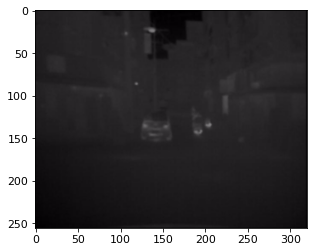

In [ ]:
plt.imshow(inp[random])

In [ ]:
target[random].min()

-0.9137255

In [ ]:
def sample_from_discretized_mix_logistic_1d(l, nr_mix):
    # Pytorch ordering
    l = l.permute(0, 2, 3, 1)
    ls = [int(y) for y in l.size()]
    xs = ls[:-1] + [1] #[3]

    # unpack parameters
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 2]) # for mean, scale

    # sample mixture indicator from softmax
    temp = torch.FloatTensor(logit_probs.size())
    if l.is_cuda : temp = temp.cuda()
    temp.uniform_(1e-5, 1. - 1e-5)
    temp = logit_probs.data - torch.log(- torch.log(temp))
    _, argmax = temp.max(dim=3)
   
    one_hot = to_one_hot(argmax, nr_mix)
    sel = one_hot.view(xs[:-1] + [1, nr_mix])
    # select logistic parameters
    means = torch.sum(l[:, :, :, :, :nr_mix] * sel, dim=4) 
    log_scales = torch.clamp(torch.sum(
        l[:, :, :, :, nr_mix:2 * nr_mix] * sel, dim=4), min=-7.)
    u = torch.FloatTensor(means.size())
    if l.is_cuda : u = u.cuda()
    u.uniform_(1e-5, 1. - 1e-5)
    u = Variable(u)
    x = means + torch.exp(log_scales) * (torch.log(u) - torch.log(1. - u))
    x0 = torch.clamp(torch.clamp(x[:, :, :, 0], min=-1.), max=1.)
    out = x0.unsqueeze(1)
    return out

In [ ]:
def sample_from_discretized_mix_logistic(l, nr_mix):
    # Pytorch ordering
    l = l.permute(0, 2, 3, 1)
    ls = [int(y) for y in l.size()]
    xs = ls[:-1] + [3]

    # unpack parameters
    logit_probs = l[:, :, :, :nr_mix]
    l = l[:, :, :, nr_mix:].contiguous().view(xs + [nr_mix * 3])
    # sample mixture indicator from softmax
    temp = torch.FloatTensor(logit_probs.size())
    if l.is_cuda : temp = temp.cuda()
    temp.uniform_(1e-5, 1. - 1e-5)
    temp = logit_probs.data - torch.log(- torch.log(temp))
    _, argmax = temp.max(dim=3)
   
    one_hot = to_one_hot(argmax, nr_mix)
    sel = one_hot.view(xs[:-1] + [1, nr_mix])
    # select logistic parameters
    means = torch.sum(l[:, :, :, :, :nr_mix] * sel, dim=4) 
    log_scales = torch.clamp(torch.sum(
        l[:, :, :, :, nr_mix:2 * nr_mix] * sel, dim=4), min=-7.)
    coeffs = torch.sum(F.tanh(
        l[:, :, :, :, 2 * nr_mix:3 * nr_mix]) * sel, dim=4)
    # sample from logistic & clip to interval
    # we don't actually round to the nearest 8bit value when sampling
    u = torch.FloatTensor(means.size())
    if l.is_cuda : u = u.cuda()
    u.uniform_(1e-5, 1. - 1e-5)
    u = torch.autograd.Variable(u)
    x = means + torch.exp(log_scales) * (torch.log(u) - torch.log(1. - u))
    x0 = torch.clamp(torch.clamp(x[:, :, :, 0], min=-1.), max=1.)
    x1 = torch.clamp(torch.clamp(
       x[:, :, :, 1] + coeffs[:, :, :, 0] * x0, min=-1.), max=1.)
    x2 = torch.clamp(torch.clamp(
       x[:, :, :, 2] + coeffs[:, :, :, 1] * x0 + coeffs[:, :, :, 2] * x1, min=-1.), max=1.)

    out = torch.cat([x0.view(xs[:-1] + [1]), x1.view(xs[:-1] + [1]), x2.view(xs[:-1] + [1])], dim=3)
    # put back in Pytorch ordering
    out = out.permute(0, 3, 1, 2)
    return out

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([4, 3, 256, 320])

In [ ]:
def to_one_hot(tensor, n, fill_with=1.):
    # we perform one hot encore with respect to the last axis
    one_hot = torch.FloatTensor(tensor.size() + (n,)).zero_()
    if tensor.is_cuda : one_hot = one_hot.cuda()
    one_hot.scatter_(len(tensor.size()), tensor.unsqueeze(-1), fill_with)
    return torch.autograd.Variable(one_hot)